In [52]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2

In [53]:
dataset_path = "C:/Users/Coli/Downloads/QuadCore-20250506T055543Z-001/QuadCore"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

In [54]:
def displayImage(image_path):
  # Path to your image file in Google Drive
  image = Image.open(image_path)

  # Display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # Hide axes for cleaner display
  plt.show()

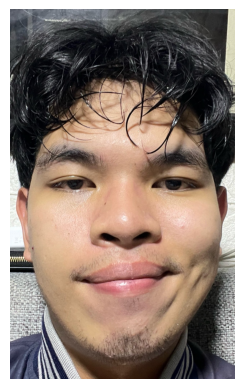

In [55]:
displayImage('/Users/Coli/Downloads/QuadCore-20250506T055543Z-001/QuadCore/images/0a4de83e-5423caf4-7e63-4b61-8e8a-7cb24f2237f9.jpg')

In [56]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

No GPU available.


In [57]:
SIZE = 256
image_size = (SIZE, SIZE)

In [58]:
X = []
y_class = []
y_bbox = []
class_ids = set()

In [59]:
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg", ".JPG")):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0

        # Load annotation
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))

            X.append(img)
            y_class.append(cls)
            y_bbox.append(bbox)
            class_ids.add(cls)

X = np.array(X, dtype=np.float32)

In [60]:
# Map class IDs to indices
class_ids = sorted(list(class_ids))
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}
num_classes = len(class_ids)

# # One-hot encode class labels
y_class = [class_to_idx[c] for c in y_class]
y_class = to_categorical(y_class, num_classes=num_classes)

y_bbox = np.array(y_bbox, dtype=np.float32)

In [61]:
len(X)

850

In [62]:
unique, counts = np.unique(np.argmax(y_class, axis=1), return_counts=True)
print(dict(zip(unique, counts)))

{0: 206, 1: 200, 2: 232, 3: 212}


In [63]:
X_train, X_test, y_cls_train, y_cls_test, y_bbox_train, y_bbox_test = train_test_split(X, y_class, y_bbox, test_size=0.2, random_state=42)

In [64]:
input_layer = layers.Input(shape=(SIZE, SIZE, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: class probabilities
class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# Output 2: bounding box (x_center, y_center, width, height)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 254, 254,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 127, 127,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 246016)    │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 31,490,176 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 4)         │        516 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,510,600 (120.20 MB)

 Trainable params: 31,510,600 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 615ms/step - bbox_output_loss: 0.0758 - class_output_accuracy: 0.3206 - class_output_loss: 5.6980 - loss: 5.7845 - val_bbox_output_loss: 0.0295 - val_class_output_accuracy: 0.7647 - val_class_output_loss: 0.4466 - val_loss: 0.6001
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 571ms/step - bbox_output_loss: 0.0241 - class_output_accuracy: 0.8199 - class_output_loss: 0.4964 - loss: 0.5215 - val_bbox_output_loss: 0.0202 - val_class_output_accuracy: 0.8676 - val_class_output_loss: 0.3334 - val_loss: 0.4031
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - bbox_output_loss: 0.0142 - class_output_accuracy: 0.9182 - class_output_loss: 0.2392 - loss: 0.2534 - val_bbox_output_loss: 0.0144 - val_class_output_accuracy: 0.8824 - val_class_output_loss: 0.2186 - val_loss: 0.3231
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 569ms/step - bbox_output_loss: 0.0127 - class_output_accuracy: 0.9728 - class_output_loss: 0.0774 - loss: 0.0905 - val_bbox_output_loss: 0.

In [66]:
model.evaluate(X_test, {'class_output': y_cls_test, 'bbox_output': y_bbox_test})

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - bbox_output_loss: 0.0086 - class_output_accuracy: 0.9345 - class_output_loss: 0.2004 - loss: 0.2138


[0.18185393512248993,
 0.15654636919498444,
 0.008494623936712742,
 0.9411764740943909]

In [67]:
# Predict on the test set
y_pred = model.predict(X_test)

# Separate class and bounding box predictions
y_cls_pred = y_pred[0]  # The class prediction (probabilities)
y_bbox_pred = y_pred[1]  # The bounding box prediction (x_center, y_center, width, height)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [69]:
y_pred = model.predict(X_test)

# Separate the predictions
y_cls_pred = y_pred[0]  # Class probabilities
y_bbox_pred = y_pred[1]  # Bounding box predictions

# Find the predicted class for each sample
predicted_classes = np.argmax(y_cls_pred, axis=1)

# Compare with true class labels (just for class prediction)
true_classes = np.argmax(y_cls_test, axis=1)

# Calculate accuracy (for class prediction)
class_accuracy = np.mean(predicted_classes == true_classes)
print(f"Class prediction accuracy: {class_accuracy:.2f}")


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step 
Class prediction accuracy: 0.94


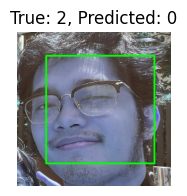

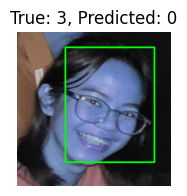

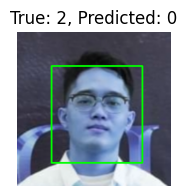

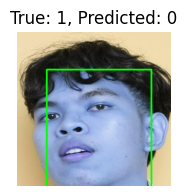

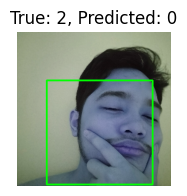

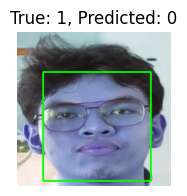

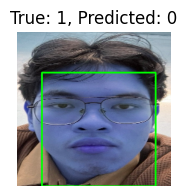

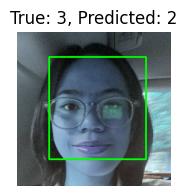

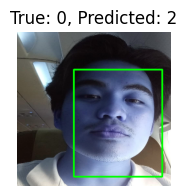

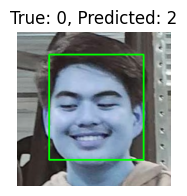

In [70]:
# Get predicted classes
predicted_classes = np.argmax(y_cls_pred, axis=1)
true_classes = np.argmax(y_cls_test, axis=1)

# Find indices where predictions were wrong
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot misclassified images
for idx in misclassified_indices:
    img = X_test[idx]
    true_class = true_classes[idx]
    pred_class = predicted_classes[idx]
    
    # Get bounding box predictions
    bbox = y_bbox_pred[idx]
    
    # Convert normalized bbox to pixel coordinates
    x_center = bbox[0] * SIZE
    y_center = bbox[1] * SIZE
    width = bbox[2] * SIZE
    height = bbox[3] * SIZE
    
    # Calculate corners
    x1 = int(x_center - width/2)
    y1 = int(y_center - height/2)
    x2 = int(x_center + width/2)
    y2 = int(y_center + height/2)
    
    # Create a copy for drawing
    img_display = (img * 255).astype(np.uint8).copy()
    
    # Draw rectangle
    cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize=(2, 2))
    plt.imshow(img_display)
    plt.title(f'True: {true_class}, Predicted: {pred_class}')
    plt.axis('off')
    plt.show()

In [71]:
from sklearn.metrics import classification_report
import numpy as np

# Convert predictions and true labels from one-hot encoding to class indices
y_pred_classes = np.argmax(y_cls_pred, axis=1)
y_true_classes = np.argmax(y_cls_test, axis=1)

# Create classification report
# Since we have 4 classes (0, 1, 2, 3), we need to specify the target names
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.95      0.89        39
     Class 1       1.00      0.94      0.97        47
     Class 2       0.93      0.93      0.93        43
     Class 3       1.00      0.95      0.97        41

    accuracy                           0.94       170
   macro avg       0.94      0.94      0.94       170
weighted avg       0.95      0.94      0.94       170



In [72]:
model.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpdmqqnqd0\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmpdmqqnqd0\assets


Saved artifact at 'C:\Users\Coli\AppData\Local\Temp\tmpdmqqnqd0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  1801881745936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881746704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881747280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881962256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881962064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881962832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881963600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881964560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881961296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1801881